# Parameterize the linear growth in 2 < z < 5

We would like to see if we can compress the linear power spectrum information in a handful of parameters.
In this notebook we focus on the linear growth.

Note that the discussion here is a bit obsolete, and an updated version can be found in the appendix of the notes.

In [1]:
%matplotlib inline
import numpy as np
import os
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import camb
from camb import model, initialpower
import fit_linP
import camb_cosmo

### Specify cosmological model 

In [2]:
cosmo = camb_cosmo.get_cosmology(mnu=0.3,H0=73.0)
camb_cosmo.print_info(cosmo)

H0 = 7.3000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 3.2257E-03, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


### Run CAMB to get power spectra

In [3]:
## output redshifts
zs=[2,2.9,3,3.1,5]
Nz=len(zs)
if Nz is not 5:
    raise ValueError("The rest of the notebook expects you use five redshifts")
iz_star=2
z_star=zs[iz_star]
if not (zs[iz_star] == 3.0):
    raise ValueError("The rest of the notebook expects the central redshift to be z_star =3")
k_Mpc, zs_out, P_Mpc = camb_cosmo.get_linP_Mpc(cosmo,zs)

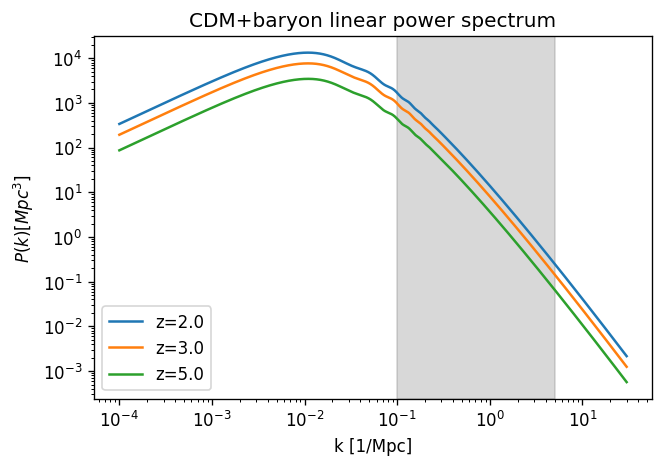

In [4]:
plt.figure()
for iz in [0,2,4]: 
    plt.loglog(k_Mpc,P_Mpc[iz],label='z='+str(zs_out[iz]))
plt.title(r"CDM+baryon linear power spectrum")
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"$P(k) [Mpc^3]$")
plt.legend()
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')

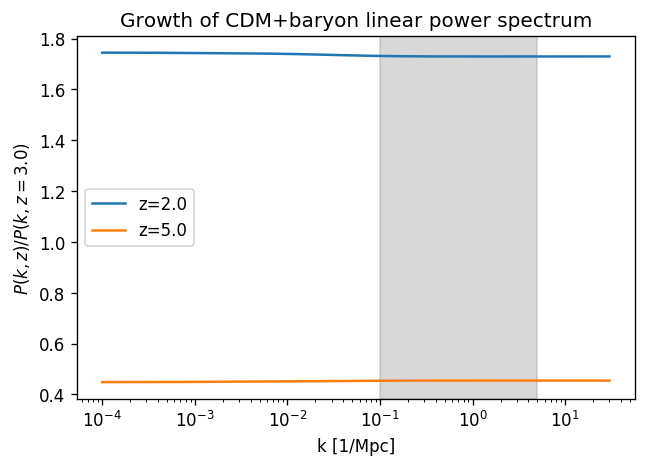

In [5]:
plt.figure()
plt.semilogx(k_Mpc,P_Mpc[0]/P_Mpc[2],label='z='+str(zs_out[0]))
plt.semilogx(k_Mpc,P_Mpc[4]/P_Mpc[2],label='z='+str(zs_out[4]))
plt.title(r"Growth of CDM+baryon linear power spectrum")
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"$P(k,z)/P(k,z="+str(zs_out[2])+")$")
plt.legend()
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')

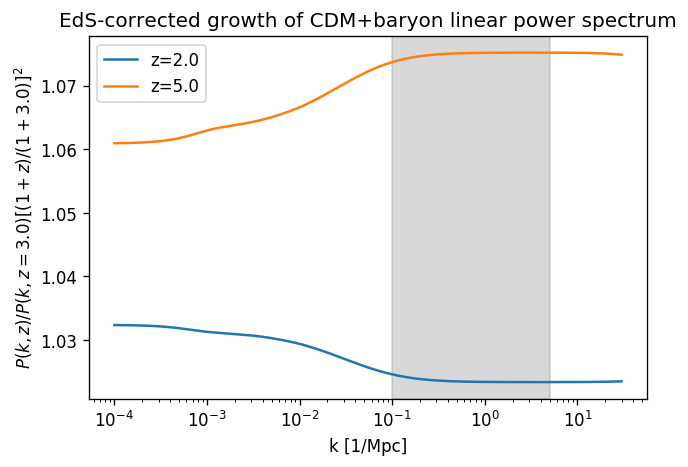

In [6]:
plt.figure()
plt.semilogx(k_Mpc,P_Mpc[0]/P_Mpc[2]*((1+zs_out[0])/(1+zs_out[1]))**2,label='z='+str(zs_out[0]))
plt.semilogx(k_Mpc,P_Mpc[4]/P_Mpc[2]*((1+zs_out[4])/(1+zs_out[1]))**2,label='z='+str(zs_out[4]))
plt.title(r"EdS-corrected growth of CDM+baryon linear power spectrum")
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"$P(k,z)/P(k,z="+str(zs_out[2])+") [(1+z)/(1+"+str(zs_out[2])+")]^2$")
plt.legend()
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')

Let us compute the linear growth, with respect Einstein-de Sitter
$$ \eta(z,k) = \frac{D(z)}{D_\star} \frac{a_\star}{a(z)} = \sqrt{\frac{P(z,k)}{P_\star(k)}} \frac{a_\star}{a(z)} $$
where quantities with $_\star$ have been evaluated at $z_\star=3$.

In [7]:
eta = np.ones_like(P_Mpc)
for iz in range(Nz):
    eta[iz]=np.sqrt(P_Mpc[iz]/P_Mpc[2])*(1+zs_out[iz])/(1+zs_out[2])

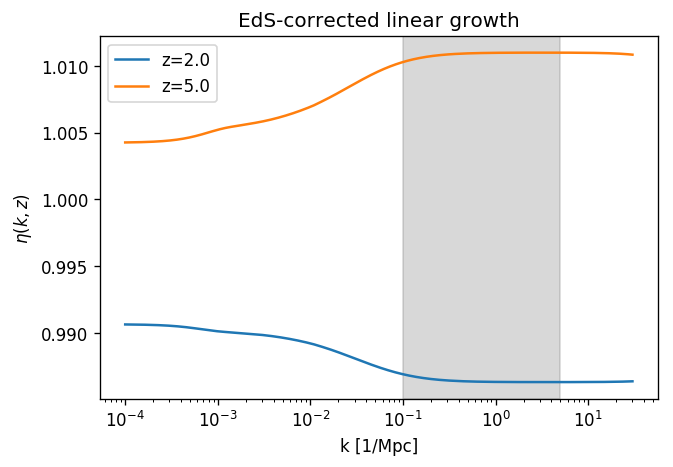

In [8]:
plt.figure()
plt.semilogx(k_Mpc,eta[0],label='z='+str(zs_out[0]))
plt.semilogx(k_Mpc,eta[4],label='z='+str(zs_out[4]))
plt.title(r"EdS-corrected linear growth")
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"$\eta(k,z)$")
plt.legend()
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')

For this particular cosmology, the differences with respect to EdS are of order 1%. 
We will now try to see if we could describe these with a single number, its derivative around $z_\star=3$, and around $k_p=1 Mpc^{-1}$.
$$ \eta(z_\star + \Delta z,k) = 1 + \frac{\partial \eta(z,k)}{\partial z} \Bigr\rvert_{z_\star} \Delta z = 1 + (1 - f_\star(k))  \frac{\Delta z}{1+z_\star} $$
with
$$ f_\star(k) = 1 - (1+z_\star)\frac{\partial \eta(z,k)}{\partial z} \Bigr\rvert_{z_\star}$$

In [9]:
deta_dz = (eta[3]-eta[1])/(zs_out[3]-zs_out[1])
f_star = 1 - (1+zs_out[2]) * deta_dz
# average value of f_star around k_p
k_p_Mpc=1.0
mask=(k_Mpc > 0.8*k_p_Mpc) & (k_Mpc < 1.2*k_p_Mpc)
f_star_p = np.mean(f_star[mask])

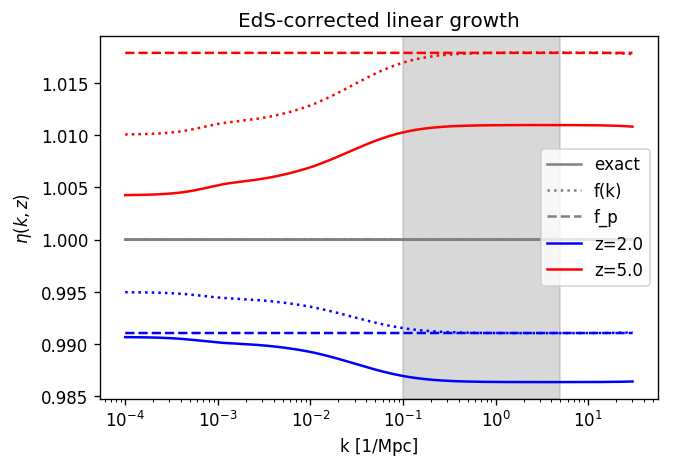

In [10]:
plt.figure()
plt.semilogx(k_Mpc,np.ones_like(k_Mpc),'-',color='gray',label='exact')
plt.semilogx(k_Mpc,np.ones_like(k_Mpc),':',color='gray',label='f(k)')
plt.semilogx(k_Mpc,np.ones_like(k_Mpc),'--',color='gray',label='f_p')
plt.semilogx(k_Mpc,eta[0],'-',color='blue',label='z='+str(zs_out[0]))
plt.semilogx(k_Mpc,eta[4],'-',color='red',label='z='+str(zs_out[4]))
plt.semilogx(k_Mpc,1+(1-f_star)*(zs_out[0]-zs_out[2])/(1+zs_out[2]),':',color='blue')
plt.semilogx(k_Mpc,1+(1-f_star)*(zs_out[4]-zs_out[2])/(1+zs_out[2]),':',color='red')
plt.semilogx(k_Mpc,np.ones_like(k_Mpc)+(1-f_star_p)*(zs_out[0]-zs_out[2])/(1+zs_out[2]),'--',color='blue')
plt.semilogx(k_Mpc,np.ones_like(k_Mpc)+(1-f_star_p)*(zs_out[4]-zs_out[2])/(1+zs_out[2]),'--',color='red')
plt.semilogx(k_Mpc,np.ones_like(k_Mpc),'-',color='gray')
plt.title(r"EdS-corrected linear growth")
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"$\eta(k,z)$")
plt.legend(loc=7)
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')

We can see here that the approximation does not work *that* well, probably because we have massive neutrinos, and $\Delta z / (1+z_\star)$ is quite large. 

In [11]:
# redo using the function in linP_params.py
print('f_star_p',f_star_p)
print('f_star_p',fit_linP.compute_f_star(cosmo,z_star=z_star))

f_star_p 0.9641942047336096
f_star_p 0.9643475603316576


### Compute relative growth with respect to fiducial cosmology

In [12]:
cosmo_fid = camb_cosmo.get_cosmology()
k_Mpc_fid, _, P_Mpc_fid = camb_cosmo.get_linP_Mpc(cosmo_fid,zs=zs)

In [13]:
camb_cosmo.print_info(cosmo)
camb_cosmo.print_info(cosmo_fid)

H0 = 7.3000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 3.2257E-03, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


In [14]:
# get eta for fiducial cosmology
eta_fid = np.ones_like(P_Mpc_fid)
for iz in range(Nz):
    eta_fid[iz]=np.sqrt(P_Mpc_fid[iz]/P_Mpc_fid[2])*(1+zs_out[iz])/(1+zs_out[2])

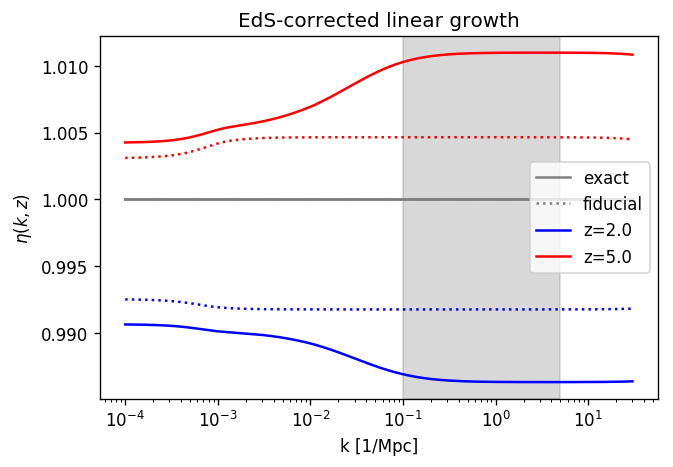

In [15]:
plt.figure()
plt.semilogx(k_Mpc,np.ones_like(k_Mpc),'-',color='gray',label='exact')
plt.semilogx(k_Mpc,np.ones_like(k_Mpc),':',color='gray',label='fiducial')
plt.semilogx(k_Mpc,eta[0],'-',color='blue',label='z='+str(zs_out[0]))
plt.semilogx(k_Mpc,eta[4],'-',color='red',label='z='+str(zs_out[4]))
plt.semilogx(k_Mpc,eta_fid[0],':',color='blue')
plt.semilogx(k_Mpc,eta_fid[4],':',color='red')
plt.semilogx(k_Mpc,np.ones_like(k_Mpc),'-',color='gray')
plt.title(r"EdS-corrected linear growth")
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"$\eta(k,z)$")
plt.legend(loc=7)
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')

We will now try to see if we could describe the differences in $\eta(z)$ using a single number, the differences in $f_\star$:
$$ \frac{D(z)}{D^0(z)}=\frac{\eta(z)}{\eta^0(z)} = 1 + (f^0_\star - f_\star)\left( \frac{z-z_\star}{1+z_\star} \right)$$

In [16]:
# compute true ratio of etas
kmin_Mpc = max(np.min(k_Mpc),np.min(k_Mpc))
kmax_Mpc = min(np.max(k_Mpc),np.max(k_Mpc))
mask = (k_Mpc > kmin_Mpc) & (k_Mpc < kmax_Mpc)
eta_0_ratio = eta[0][mask] / np.interp(k_Mpc[mask],k_Mpc_fid,eta_fid[0])
eta_4_ratio = eta[4][mask] / np.interp(k_Mpc[mask],k_Mpc_fid,eta_fid[4])

In [17]:
# compute f_star for fiducial cosmology
f_star_p_fid=fit_linP.compute_f_star(cosmo_fid,z_star=z_star)

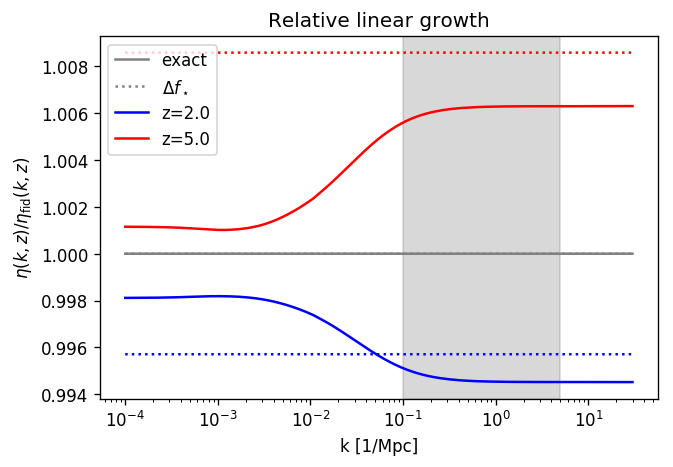

In [18]:
plt.figure()
plt.semilogx(k_Mpc[mask],np.ones_like(k_Mpc[mask]),'-',color='gray',label='exact')
plt.semilogx(k_Mpc[mask],np.ones_like(k_Mpc[mask]),':',color='gray',label=r'$\Delta f_\star$')
plt.semilogx(k_Mpc[mask],eta_0_ratio,'-',color='blue',label='z='+str(zs_out[0]))
plt.semilogx(k_Mpc[mask],eta_4_ratio,'-',color='red',label='z='+str(zs_out[4]))
plt.semilogx(k_Mpc[mask],np.ones_like(k_Mpc[mask])+(f_star_p_fid-f_star_p)*(zs_out[0]-zs_out[2])/(1+zs_out[2]),':',color='blue')
plt.semilogx(k_Mpc[mask],np.ones_like(k_Mpc[mask])+(f_star_p_fid-f_star_p)*(zs_out[4]-zs_out[2])/(1+zs_out[2]),':',color='red')
plt.title(r"Relative linear growth")
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"$\eta(k,z) / \eta_{\rm fid}(k,z)$")
plt.legend()
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')

It looks like we don't really need $f_\star$ to start with... at least for these cosmologies. It also looks like the approximation works decently well, even in the presence of neutrinos.

However, remember that we will also need $f_\star$ or similar to compute velocity power spectra, for RSD.